## DeepLoop Prediction

This notebook will walk through how to utilize the pretrained LoopDenoise and LoopEnhance models. Users can feed entire chromosomes or genomes into our provided scripts to run the models on a whole dataset using the same matrix splitting that we use in the paper. Users can also load the models into their own Python scripts and use them in their own workflows.

### Using trained models

This first cell contains the function we use to visualize significant interactions as well as some necessary imports for this notebook.

In [330]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'  # force tensorflow to run on CPU
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-deep')

def draw_heatmap(matrix, color_scale, ax=None, min_val=1.001, return_image=False, return_plt_im=False):
    """
    Display ratio heatmap containing only strong signals (values > 1 or 0.98th quantile)
    Args:
        matrix (:obj:`numpy.array`) : ratio matrix to be displayed
        color_scale (:obj:`int`) : max ratio value to be considered strongest by color mapping
        ax (:obj:`matplotlib.axes.Axes`) : axes which will contain the heatmap.  If None, new axes are created
        return_image (:obj:`bool`) : set to True to return the image obtained from drawing the heatmap with the generated color map
    Returns:
        ``numpy.array`` : if ``return_image`` is set to True, return the heatmap as an array
    """
    if color_scale != 0:
        breaks = np.append(np.arange(min_val, color_scale, (color_scale - min_val) / 18), np.max(matrix))
    elif np.max(matrix) < 2:
        breaks = np.arange(min_val, np.max(matrix), (np.max(matrix) - min_val) / 19)
    else:
        step = (np.quantile(matrix, q=0.98) - 1) / 18
        up = np.quantile(matrix, q=0.98) + 0.011
        if up < 2:
            up = 2
            step = 0.999 / 18
        breaks = np.append(np.arange(min_val, up, step), np.max(matrix) + 0.01)
    n_bin = 20  # Discretizes the interpolation into bins
    colors = ["#FFFFFF", "#FFE4E4", "#FFD7D7", "#FFC9C9", "#FFBCBC", "#FFAEAE", "#FFA1A1", "#FF9494", "#FF8686",
              "#FF7979", "#FF6B6B", "#FF5E5E", "#FF5151", "#FF4343", "#FF3636", "#FF2828", "#FF1B1B", "#FF0D0D",
              "#FF0000"]
    cmap_name = 'deeploop'
    # Create the colormap
    cm = matplotlib.colors.LinearSegmentedColormap.from_list(
        cmap_name, colors, N=n_bin)
    norm = matplotlib.colors.BoundaryNorm(breaks, 20)
    # Fewer bins will result in "coarser" colomap interpolation
    if ax is None:
        _, ax = plt.subplots()
    img = ax.imshow(matrix, cmap=cm, norm=norm, interpolation=None)
    if return_image:
        plt.close()
        return img.get_array()
    elif return_plt_im:
        return img

Usually we are interested in denoising an entire chromosome or an entire genome (within 2Mb interactions). However, since DeepLoop models are trained on small matrix tiles, we need to split each chromosome matrix into these tiles, run the model prediction, then recombine them. We provide scripts to easily run prediction and recombination of whole chromosomes or an entire genome.

### LoopDenoise Prediction

In [30]:
! python3 ../prediction/predict_chromosome.py --full_matrix_dir ../training_data/H9_full/ \
                                              --input_name anchor_2_anchor.loop.chr11.p_val \
                                              --h5_file models/denoise_model/cp_gz_denoise.h5 \
                                              --out_dir output/H9_denoised/ \
                                              --anchor_dir ../training_data/anchor_bed/ \
                                              --chromosome chr11 \
                                              --small_matrix_size 128 \
                                              --step_size 128 \
                                              --dummy 5;

2021-08-18 10:08:43.455646: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-18 10:08:43.455691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-18 10:08:46.868960: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-18 10:08:46.869003: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-18 10:08:46.869046: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runn

This script will output the denoised or enhanced interactions as a tab-separated list of `anchor1` `anchor2` `value` triplets. If you would like, you can use our `convert_to_cooler.py` script to convert any interactions of this format into a cooler file.

In [26]:
! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir ../training_data/H9_full/ \
                                        --out_file coolers/H9_full_chr11.cool \
                                        --col_names a1 a2 obs exp pval \
                                        --cooler_col ratio \
                                        --single_chrom chr11;

coolers/H9_full_chr11.cool
100%|███████████████████████████████████████████| 24/24 [00:32<00:00,  1.37s/it]
            a1     a2     ratio
0            1      2  1.000000
1            1      3  1.000000
2            1      4  1.000000
3            1      5  1.000000
4            1      6  1.000000
...        ...    ...       ...
3503151  15366  15368  1.115758
3503152  15366  15369  1.295213
3503153  15367  15368  0.974197
3503154  15367  15369  1.391382
3503155  15368  15369  1.584044

[3503156 rows x 3 columns]
a1         int64
a2         int64
ratio    float64
dtype: object


In [187]:
! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir output/H9_denoised/ \
                                        --out_file coolers/H9_denoise_chr11.cool \
                                        --col_names a1 a2 denoise \
                                        --cooler_col denoise \
                                        --single_chrom chr11;

coolers/H9_denoise_chr11.cool
100%|█████████████████████████████████████████████| 4/4 [00:10<00:00,  2.58s/it]
            a1     a2  denoise
0            0      1   0.0346
1            0      2   0.0226
2            0      3   0.0298
3            0      4   0.0366
4            0      5   0.0406
...        ...    ...      ...
4829997  15356  15358   0.0346
4829998  15356  15359   0.0453
4829999  15357  15358   0.0298
4830000  15357  15359   0.0395
4830001  15358  15359   0.0426

[4830002 rows x 3 columns]
a1           int64
a2           int64
denoise    float64
dtype: object
Saving cooler...
15358 15359 15370


Now we can easily visualize heatmaps by loading the cooler file and accessing the matrix.

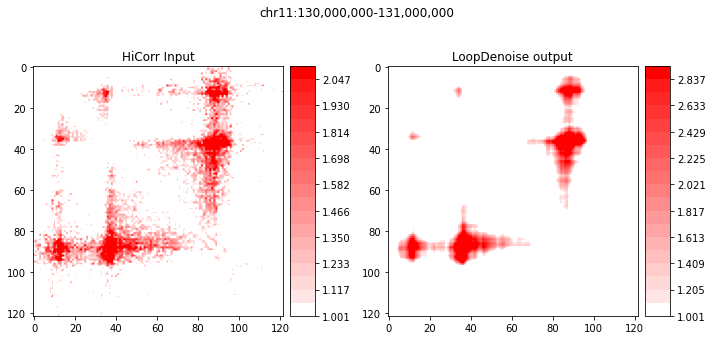

In [188]:
import cooler

locus = 'chr11:130,000,000-131,000,000'

c_denoise = cooler.Cooler('coolers/H9_denoise_chr11.cool')
c_ratio = cooler.Cooler('coolers/H9_full_chr11.cool')
mat_denoise = c_denoise.matrix().fetch(locus)
mat_ratio = c_ratio.matrix().fetch(locus)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = draw_heatmap(mat_ratio, 0, ax=axs[0], return_plt_im=True)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0].set_title('HiCorr Input')

im = draw_heatmap(mat_denoise, 0, ax=axs[1], return_plt_im=True)
#im = axs[1].imshow(mat_denoise, cmap='Reds')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1].set_title('LoopDenoise output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()

### LoopEnhance Prediction

In [50]:
! python3 ../prediction/predict_chromosome.py --full_matrix_dir ../training_data/H9_15M/rep1/ \
                                              --input_name anchor_2_anchor.loop.chr11 \
                                              --h5_file models/enhance_model/enhance_CP_GZ_015.h5 \
                                              --out_dir output/H9_15M_enhance/ \
                                              --anchor_dir ../training_data/anchor_bed/ \
                                              --chromosome chr11 \
                                              --small_matrix_size 128 \
                                              --step_size 128 \
                                              --dummy 5;

! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir ../training_data/H9_15M/rep1/ \
                                        --out_file coolers/H9_15M_chr11.cool \
                                        --col_names a1 a2 obs exp \
                                        --cooler_col ratio \
                                        --single_chrom chr11;

! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir output/H9_15M_enhance/ \
                                        --out_file coolers/H9_15M_enhance_chr11.cool \
                                        --col_names a1 a2 enhance \
                                        --cooler_col enhance \
                                        --single_chrom chr11;

2021-08-18 10:42:40.317182: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-18 10:42:40.317225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-18 10:42:43.622753: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/biotools/lib64:/INSTALLS/ROOT/root-5.34.32/lib
2021-08-18 10:42:43.622797: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-18 10:42:43.622836: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runn

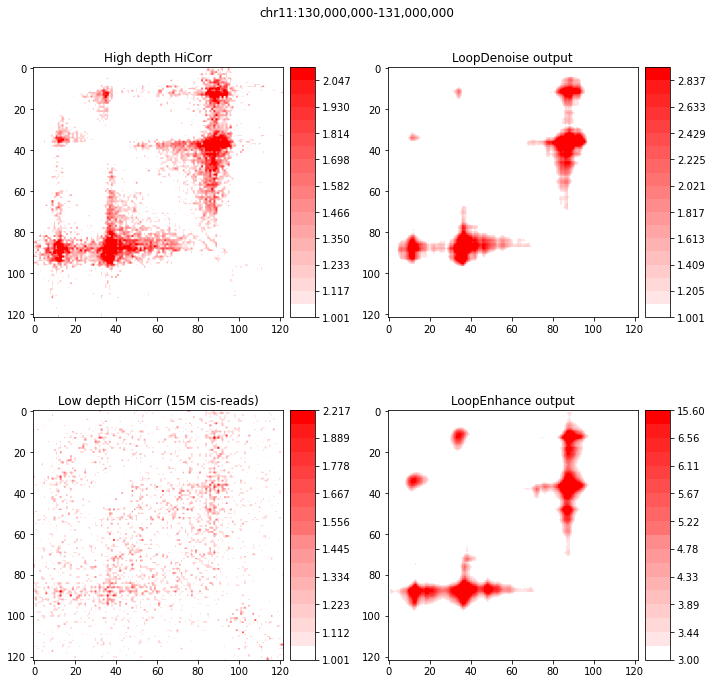

In [334]:
c_denoise = cooler.Cooler('coolers/H9_denoise_chr11.cool')
c_ratio_full = cooler.Cooler('coolers/H9_full_chr11.cool')
c_ratio_down = cooler.Cooler('coolers/H9_15M_chr11.cool')
c_enhance = cooler.Cooler('coolers/H9_15M_enhance_chr11.cool')

mat_denoise = c_denoise.matrix().fetch(locus)
mat_ratio_full = c_ratio_full.matrix().fetch(locus)
mat_enhance = c_enhance.matrix().fetch(locus)
mat_ratio_down = c_ratio_down.matrix().fetch(locus)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

im = draw_heatmap(mat_ratio, 0, ax=axs[0][0], return_plt_im=True)
divider = make_axes_locatable(axs[0][0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0][0].set_title('High depth HiCorr')

im = draw_heatmap(mat_denoise, 0, ax=axs[0][1], return_plt_im=True)
divider = make_axes_locatable(axs[0][1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0][1].set_title('LoopDenoise output')

im = draw_heatmap(mat_ratio_down, 0, ax=axs[1][0], return_plt_im=True)
divider = make_axes_locatable(axs[1][0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1][0].set_title('Low depth HiCorr (15M cis-reads)')

im = draw_heatmap(mat_enhance, 7, min_val=3, ax=axs[1][1], return_plt_im=True)
divider = make_axes_locatable(axs[1][1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1][1].set_title('LoopEnhance output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()

### Integrating models directly into your workflow

Once a model is trained and saved, it can be used to denoise new Hi-C matrices in your own scripts. To load a model, we use the `.json` file to load the architecture and the `.h5` file to load the trained weights. Note that TensorFlow can also save the full model and training state as a `.h5` file using the `model.save()` function

In [335]:
from tensorflow.keras.models import model_from_json

json_file = 'models/denoise_model/cp_gz_denoise.json'
h5_file = 'models/denoise_model/cp_gz_denoise.h5'

with open(json_file, 'r') as f:
    model = model_from_json(f.read())  # load model
model.load_weights(h5_file)  # load model weights
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     1360      
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 8)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 8)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     10824     
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 8)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 8)     0   

Here we will demonstrate how to denoise and visualize a heatmap starting from a cooler file. For completeness, the cell below demonstrates how we generated the cooler file we will be using.

In [310]:
! python3 ../utils/convert_to_cooler.py --anchor_dir ../training_data/anchor_bed/ \
                                        --loop_dir ../training_data/H9_full/ \
                                        --out_file coolers/H9_full.cool \
                                        --col_names a1 a2 obs exp pval \
                                        --cooler_col ratio;

coolers/H9_full.cool
100%|███████████████████████████████████████████| 24/24 [08:20<00:00, 20.83s/it]
              a1      a2     ratio   chr  chr_a1  chr_a2
0              0       1  0.981176  chr1       0       1
1              0       2  1.000000  chr1       0       2
2              0       3  0.999842  chr1       0       3
3              0       4  1.000000  chr1       0       4
4              0       5  0.997847  chr1       0       5
...          ...     ...       ...   ...     ...     ...
77069316  334610  334612  1.000000  chrY    2987    2989
77069317  334610  334613  1.000000  chrY    2987    2990
77069318  334611  334612  1.000000  chrY    2988    2989
77069319  334611  334613  1.000000  chrY    2988    2990
77069320  334612  334613  1.000000  chrY    2989    2990

[77069321 rows x 6 columns]
a1          int64
a2          int64
ratio     float64
chr        object
chr_a1      int64
chr_a2      int64
dtype: object
Saving cooler...
334612 334613 334614


In [336]:
c = cooler.Cooler('coolers/H9_full.cool')
c.info

{'bin-size': None,
 'bin-type': 'variable',
 'creation-date': '2021-08-19T10:09:27.240557',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/open2c/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.11',
 'genome-assembly': 'hg19',
 'metadata': {},
 'nbins': 334614,
 'nchroms': 24,
 'nnz': 77069321,
 'storage-mode': 'symmetric-upper',
 'sum': 79341555.57598312}

In [312]:
locus = 'chr11:130,000,000-131,000,000'

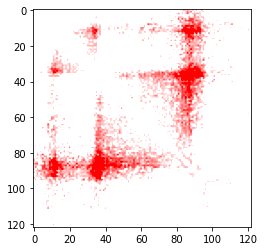

In [313]:
mat = c.matrix().fetch(locus)
draw_heatmap(mat, 0)

Typically, we would denoise many heatmaps at once in a batch. Additionally, the model expects each heatmap to have a single channel. So we need to ensure that the input is a 4-dimensional array. In the case of a single heatmap this corresponds to a shape of `(1, _, _, 1)`

In [337]:
def add_dims(x):
    if len(x.shape) == 2:
        return np.expand_dims(np.expand_dims(x, 0), -1)
    elif len(x.shape) == 3:
        return np.expand_dims(x, -1)
    else:
        return x

Here we use the model to predict the denoised values, then we force the output matrix to be symmetric by averaging across the diagonal.

In [338]:
enhanced_mat = model.predict(add_dims(mat))[0, ..., 0]
enhanced_mat = (enhanced_mat + enhanced_mat.T) / 2

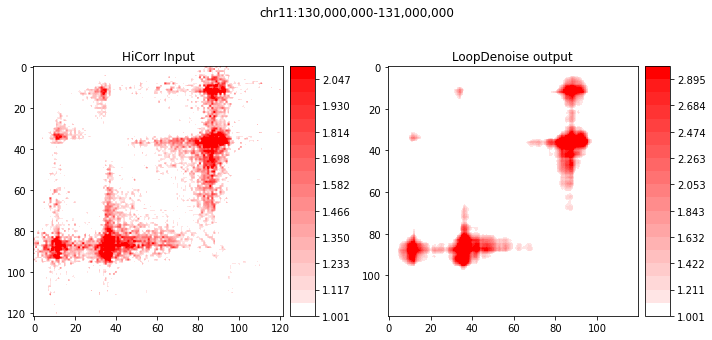

In [339]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = draw_heatmap(mat, 0, ax=axs[0], return_plt_im=True)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0].set_title('HiCorr Input')

im = draw_heatmap(enhanced_mat, 0, ax=axs[1], return_plt_im=True)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1].set_title('LoopDenoise output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()

### LoopEnhance Demo

The LoopEnhance models can used in nearly the exact same way has the LoopDenoise models. However, due to the pooling layers and skip connections, we require that your input be at least divisible by $2^d$ where $d$ is the depth of the model (we use $d=4$ in our models).

In [340]:
json_file = 'models/enhance_model/enhance_CP_GZ_015.json'
h5_file = 'models/enhance_model/enhance_CP_GZ_015.h5'

with open(json_file, 'r') as f:
    model = model_from_json(f.read())  # load model
model.load_weights(h5_file)  # load model weights
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 4 328         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 4 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 4 1300        activation_1[0][0]               
____________________________________________________________________________________________

In [25]:
c = cooler.Cooler('GM_17M_ratio_anchor.cool')
locus = 'chr4:11,000,000-12,055,000'
mat = c.matrix().fetch(locus)
mat.shape

(128, 128)

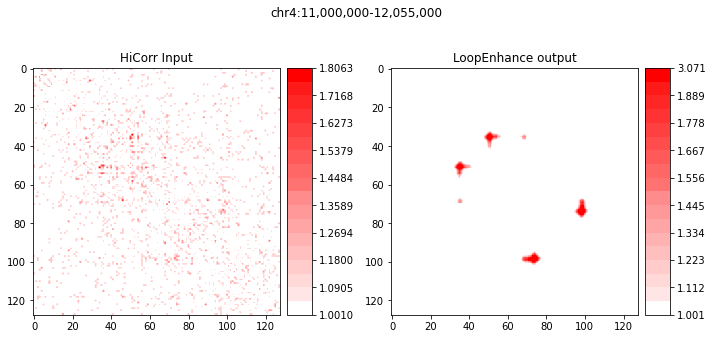

In [26]:
enhanced_mat = model.predict(add_dims(mat))[0, ..., 0]
enhanced_mat = (enhanced_mat + enhanced_mat.T) / 2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im = draw_heatmap(mat, 0, ax=axs[0], return_plt_im=True)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[0].set_title('HiCorr Input')

im = draw_heatmap(enhanced_mat, 0, ax=axs[1], return_plt_im=True)
divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='10%', pad=0.1)
cbar1 = fig.colorbar(im, cax=cax, orientation='vertical')
axs[1].set_title('LoopEnhance output')

fig.suptitle(locus)
fig.tight_layout()
plt.show()